## Graph Hot Spots Conjecture: Experiments
Arya Maheshwari

Testing graph hot spots conjecture on different examples of graphs and to come up with possible conditions for which conjecture could hold (combinations of planarity, convexity, etc) 

In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import math

### A. Step by step definition of testing procedure

#### 1a. Generate graphs
<font color='purple'> Key part of project: </font> Testing wide variety of graphs, algorithmically/programmatically <font color='red'> (TBD) </font>
<br> - checking convexity examples (convex, strictly convex)
<br> - checking planarity examples

In [2]:
# generate some test graph for now

# G = nx.random_powerlaw_tree(15)
G = nx.grid_2d_graph(5, 10)
# G = nx.complete_graph(5)


node_list = list(G.nodes)

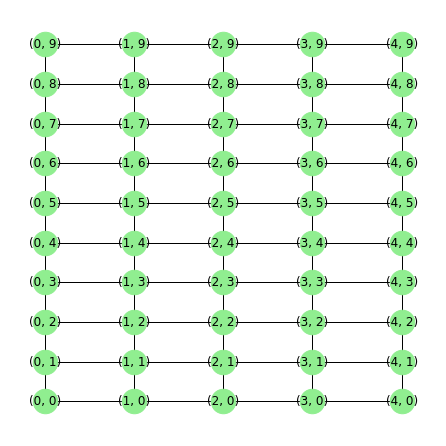

In [3]:
# FOR GRID GRAPH
plt.figure(figsize=(6,6))

pos = {(x,y):(x,y) for x,y in G.nodes()}
nx.draw(G, pos, with_labels=True, node_color='lightgreen', node_size=600)

# FOR OTHER GRAPH
# nx.draw(G, with_labels=True, node_color='lightgreen', node_size=600)


#### 1b. Check planarity

In [4]:
is_planar, P = nx.check_planarity(G)
print(is_planar)

True


#### 2. Compute boundary of graph
Brute-force algorithm based on $\partial G$ as defined in https://arxiv.org/pdf/2201.03489.pdf:

In [191]:
def compute_boundary(G):
    '''
    Returns list of nodes in G that are in the boundary.
    '''
    # compute shortest path lengths between all vertices
    path_dist = dict(nx.all_pairs_shortest_path_length(G))

    boundary = []
    for u in list(G.nodes): 
        for v in list(G.nodes): # test all v for witness of u as boundary vertex
            dsum = 0
            for w in G.neighbors(u):
                dsum += path_dist[w][v] # compute sum of distances from v to neighbors of u (= w)
            if(path_dist[u][v] > dsum/len(G[u])):
                boundary.append(u)
                
                # --- INSPECTING SPECIFIC CASE FOR BRICK TEST: delete this code otherwise
#                 if(str(u)=="(10, 13)"):
#                     for w in G.neighbors(u):
#                         print(path_dist[w][v])
#                     print('u-v dist:', path_dist[u][v])
#                 print(u, "witnessed by", v)
                # ------------------------------------------------------------------------
                break # move on to next vertex to test for boundary
    
    return boundary

In [192]:
boundary = compute_boundary(G)
bound_set = set(boundary)

#### 2b. Check (strict) convexity

In [183]:
def is_convex(G, bound_set, strict=False):
    apsp = dict(nx.all_pairs_shortest_path(G))
    for u in list(G.nodes):
        if (u in bound_set) and not strict: 
            continue
        for v in list(G.nodes):
            if (v in bound_set) and not strict: 
                continue
            for path_node in apsp[u][v]:
                if (path_node != u and path_node != v and path_node in bound_set):
                    return False
    return True

In [8]:
print(is_convex(G, bound_set))
print(is_convex(G, bound_set, strict=True))

True
False


#### 3. Compute second-smallest eigenfunction $\phi_2$
To understand multiplicity: using numpy.eig
Previously: directly from networkx fiedler_vector method

In [9]:
mesh_delta = 0.001 # discretizing linear combinations

In [10]:
def fiedler(G):
    L = nx.laplacian_matrix(G).toarray()
    evals, evecs = np.linalg.eig(L)
    idx = evals.argsort()   
    evals = evals[idx]
    evecs = evecs[:,idx]
    
#     for j in range(len(evecs[0])):
#         print(evecs[:,j])
    
    fiedler_val = evals[1]
    fied_set = [evecs[:,1]]
     # second smallest eigenvalue
    if(math.isclose(evals[0], fiedler_val, rel_tol=1e-7)): # checks float equality
        fied_set.add(evecs[:,0]) # this should only happen when graph disconnected <=> phi2 = 0 since phi1 = 0 always
    i = 2 
    while(i < len(G.nodes) and math.isclose(evals[i], fiedler_val)):
#         print("here")
        fied_set.append(evecs[:,i])
        i+=1
    
    return fied_set

In [11]:
# these are not currently agreeing?
phi2_nx = nx.fiedler_vector(G, method='tracemin_lu')
phi2 = fiedler(G)[0]
print()
print(phi2_nx)
print()
print(phi2)



[-0.19753767 -0.1782013  -0.14142136 -0.0907981  -0.03128689  0.03128689
  0.0907981   0.14142136  0.17820131  0.19753767 -0.19753767 -0.1782013
 -0.14142136 -0.0907981  -0.03128689  0.03128689  0.0907981   0.14142136
  0.17820131  0.19753767 -0.19753767 -0.1782013  -0.14142136 -0.0907981
 -0.03128689  0.03128689  0.0907981   0.14142136  0.1782013   0.19753767
 -0.19753767 -0.17820131 -0.14142136 -0.0907981  -0.03128689  0.03128689
  0.0907981   0.14142136  0.1782013   0.19753767 -0.19753767 -0.17820131
 -0.14142136 -0.0907981  -0.03128689  0.03128689  0.0907981   0.14142136
  0.1782013   0.19753767]

[ 0.19753767  0.1782013   0.14142136  0.0907981   0.03128689 -0.03128689
 -0.0907981  -0.14142136 -0.1782013  -0.19753767  0.19753767  0.1782013
  0.14142136  0.0907981   0.03128689 -0.03128689 -0.0907981  -0.14142136
 -0.1782013  -0.19753767  0.19753767  0.1782013   0.14142136  0.0907981
  0.03128689 -0.03128689 -0.0907981  -0.14142136 -0.1782013  -0.19753767
  0.19753767  0.1782013   0

#### 4. Check conjecture: are smallest and largest values on boundary?

In [12]:
# NOTE: update from below: need to check *SET* of min or max values in fiedler vector

min_node = node_list[list(phi2).index(min(phi2))]
max_node = node_list[list(phi2).index(max(phi2))]

print("Maximum node in Fiedler vector:",max_node)
print("On boundary?", (max_node in bound_set))
print("Minimum node in Fiedler vector:",min_node)
print("On boundary?", (min_node in bound_set))


Maximum node in Fiedler vector: (3, 0)
On boundary? True
Minimum node in Fiedler vector: (4, 9)
On boundary? True


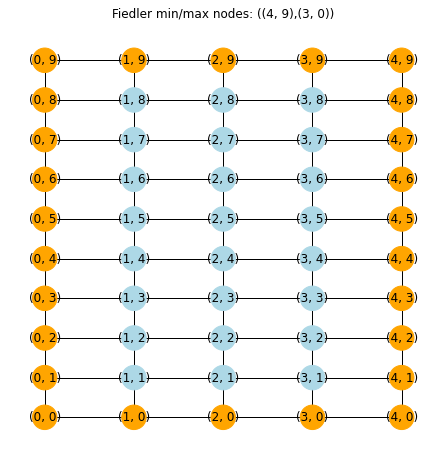

In [13]:
# visualize obtained boundary in graph drawing
plt.figure(figsize=(6,6))
colors = ['orange' if n in bound_set else 'lightblue' for n in list(G.nodes)]
pos = {(x,y):(x,y) for x,y in G.nodes()}

nx.draw(G, node_color=colors, pos=pos, with_labels=True, node_size=600)

plt.title("Fiedler min/max nodes: ("+str(min_node)+","+str(max_node)+")")
plt.show()

---
---
### Main function: CHECK CONJECTURE

In [207]:
def check_conjecture(G, pos=None, verbose=True, plot=True, with_lab=True, sz=600, fig_size=(12,12)):
    '''
    Returns: (1)min Fiedler node, (2) max Fiedler node, (3) is planar?, (4) is convex?, (5) is strictly convex? (6) boundary set
    '''
    node_list = list(G.nodes)
    
    bound = compute_boundary(G)
    bound_set = set(bound)
#     print('boundary computed')
    
    is_plan, P = nx.check_planarity(G)
    is_conv = is_convex(G, bound_set)
    is_strict_conv = is_convex(G, bound_set, strict=True)
#     print('conditions checked')
    
    phi2 = fiedler(G)[0]
    if(len(fiedler(G)) > 1):
        print('PHI2 MULTIPLICITY')
#     phi2 = nx.fiedler_vector(G, method='tracemin_lu')
#     print('fiedler computed')


    min_val = min(phi2)
    max_val = max(phi2)
    min_node_inds = [i for i in range(len(phi2)) if math.isclose(phi2[i], min_val, rel_tol=1e-7)]
    max_node_inds = [i for i in range(len(phi2)) if math.isclose(phi2[i], max_val, rel_tol=1e-7)]
   
    min_nodes = [node_list[i] for i in range(len(node_list)) if i in min_node_inds]
    max_nodes = [node_list[i] for i in range(len(node_list)) if i in max_node_inds]
    
    conj_min = True
    for x in min_nodes:
        if x not in bound_set:
            conj_min=False
            
    conj_max = True
    for x in max_nodes:
        if x not in bound_set:
            conj_max=False
    
    if verbose:
        print("Fiedler vector", phi2)
        print("Planar?", is_plan)
        print("Convex?", is_conv)
        print("Strictly convex?", is_strict_conv)
        print()
        print("Maximum nodes in Fiedler vector:",max_nodes)
        print("All on boundary?", conj_max)
        print("Minimum nodes in Fiedler vector:",min_nodes)
        print("All on boundary?", conj_min)
    print("Result:", conj_min and conj_max)
    
    if plot:
        plt.figure(figsize=fig_size)
        colors = ['orange' if n in bound_set else 'lightblue' for n in list(G.nodes)]

        if pos is not None:  
            nx.draw(G, node_color=colors, pos=pos, with_labels=with_lab, node_size=sz)
        else:
            nx.draw(G, node_color=colors, with_labels=with_lab, node_size=sz)

        plt.title("Fiedler min/max nodes: ("+str(min_nodes)+","+str(max_nodes)+")")
        plt.show()
    
    return (conj_max and conj_min), min_nodes, max_nodes, is_plan, is_conv, is_strict_conv, bound_set

---
---

### E. Testing out possible planar counterexample
Based on PDE counterexamples from Andreas Kleefeld's paper 
https://arxiv.org/pdf/2101.01210.pdf

#### Possible example 1: "brick" counterexample on page 26

A. Generate brick geometry boundary

In [ ]:
! pip install shapely

In [209]:
scale = 3

In [210]:
inner_boundary = scale*np.array([[1,2],[3,2],[3,3],[4,3],[4,2],[6,2],[6,3],[7,3],[7,2],[9,2],[9,5],[7,5],[7,4],[6,4],[6,5],[4,5],[4,4],[3,4],[3,5],[1,5],[1,2]])
outer_boundary = scale*np.array([[0, 1], [3,1], [3,0],[4,0],[4,1],[6,1],[6,0],[7,0],[7,1],[10,1],[10,6],[7,6],[7,7],[6,7],[6,6],[4,6],[4,7],[3,7],[3,6],[0,6],[0,1]])


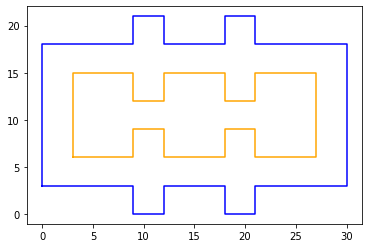

In [211]:
from shapely.geometry import Point, Polygon

outer_poly = Polygon(outer_boundary)
plt.plot(*outer_poly.exterior.xy, color='blue')
inner_poly = Polygon(inner_boundary)
plt.plot(*inner_poly.exterior.xy, color='orange')

In [212]:
def point_in_region(p, outer_poly, inner_poly):
    p = Point(p[0], p[1])
    return (p.within(outer_poly) or p.touches(outer_poly)) and not (p.within(inner_poly))

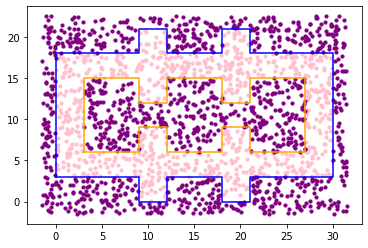

In [213]:
ntest = 2000
points = np.array([[random.uniform()*(11*scale)-(0.5*scale),random.uniform()*(8*scale)-(0.5*scale)]  for i in range(ntest)])

inside = []
outside = []
for p in points: 
    if(point_in_region(p, outer_poly, inner_poly)):
        inside.append(p)
    else:
        outside.append(p)

inside = np.array(inside)
outside = np.array(outside)

plt.scatter(inside[:,0], inside[:,1], color='pink', s=10)
plt.scatter(outside[:,0], outside[:,1], color='purple', s=10)
plt.plot(*outer_poly.exterior.xy, color='blue')
plt.plot(*inner_poly.exterior.xy, color='orange')

B. Generate graph version of brick geometry

In [214]:
# node_xpos = np.arange(0, 10.5*scale) # since original x-max was 10 (10.5 just for some buffer to be safe)
# node_ypos = np.arange(0, 7.5*scale) # since original y-max was 7

brick_G = nx.grid_2d_graph(int(10.5*scale), int(7.5*scale))
print(len(brick_G.nodes))

brick_nodes = list(brick_G.nodes) # these nodes now give us positions 
for node in brick_nodes:
    if not point_in_region(node, outer_poly, inner_poly):
        brick_G.remove_node(node)
    
print(len(brick_G.nodes))


682
408


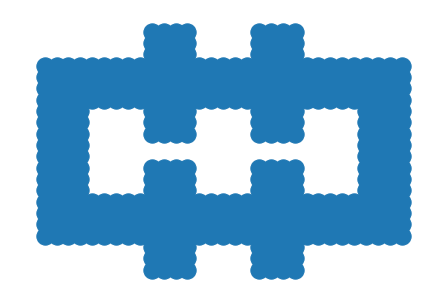

In [215]:
brick_pos = {(x,y):(x,y) for x,y in brick_G.nodes()}
nx.draw(brick_G, pos=brick_pos)

C. Test conjecture on graph

Result: True


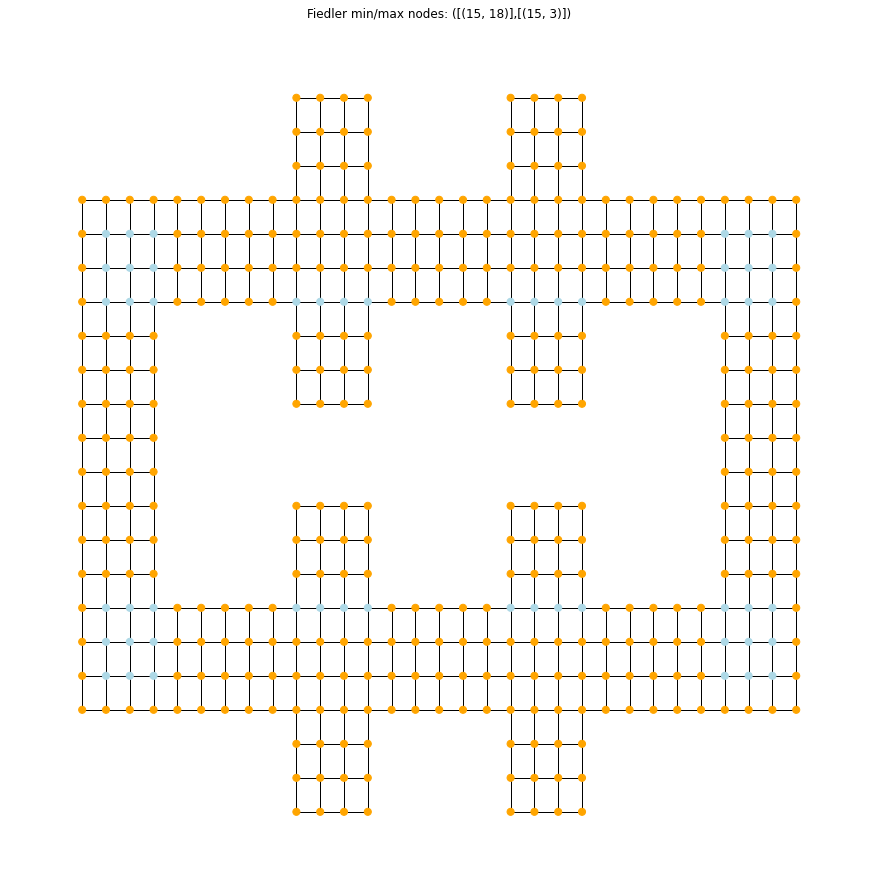

In [216]:
conj, min_node, max_node, is_plan, is_conv, is_strict_conv, bound_set = check_conjecture(
    brick_G, verbose=False, pos=brick_pos, with_lab=False, sz=50)

D. Larger tests: higher scale

In [217]:
scale = 10

In [218]:
inner_boundary = scale*np.array([[1,2],[3,2],[3,3],[4,3],[4,2],[6,2],[6,3],[7,3],[7,2],[9,2],[9,5],[7,5],[7,4],[6,4],[6,5],[4,5],[4,4],[3,4],[3,5],[1,5],[1,2]])
outer_boundary = scale*np.array([[0, 1], [3,1], [3,0],[4,0],[4,1],[6,1],[6,0],[7,0],[7,1],[10,1],[10,6],[7,6],[7,7],[6,7],[6,6],[4,6],[4,7],[3,7],[3,6],[0,6],[0,1]])
outer_poly = Polygon(outer_boundary)
inner_poly = Polygon(inner_boundary)

In [221]:
brick_G = nx.grid_2d_graph(int(10.5*scale), int(7.5*scale))
print(len(brick_G.nodes))

brick_nodes = list(brick_G.nodes) # these nodes now give us positions 
for node in brick_nodes:
    if not point_in_region(node, outer_poly, inner_poly):
        brick_G.remove_node(node)
    
print(len(brick_G.nodes))
brick_pos = {(x,y):(x,y) for x,y in brick_G.nodes()}

7875
3740


Result: True


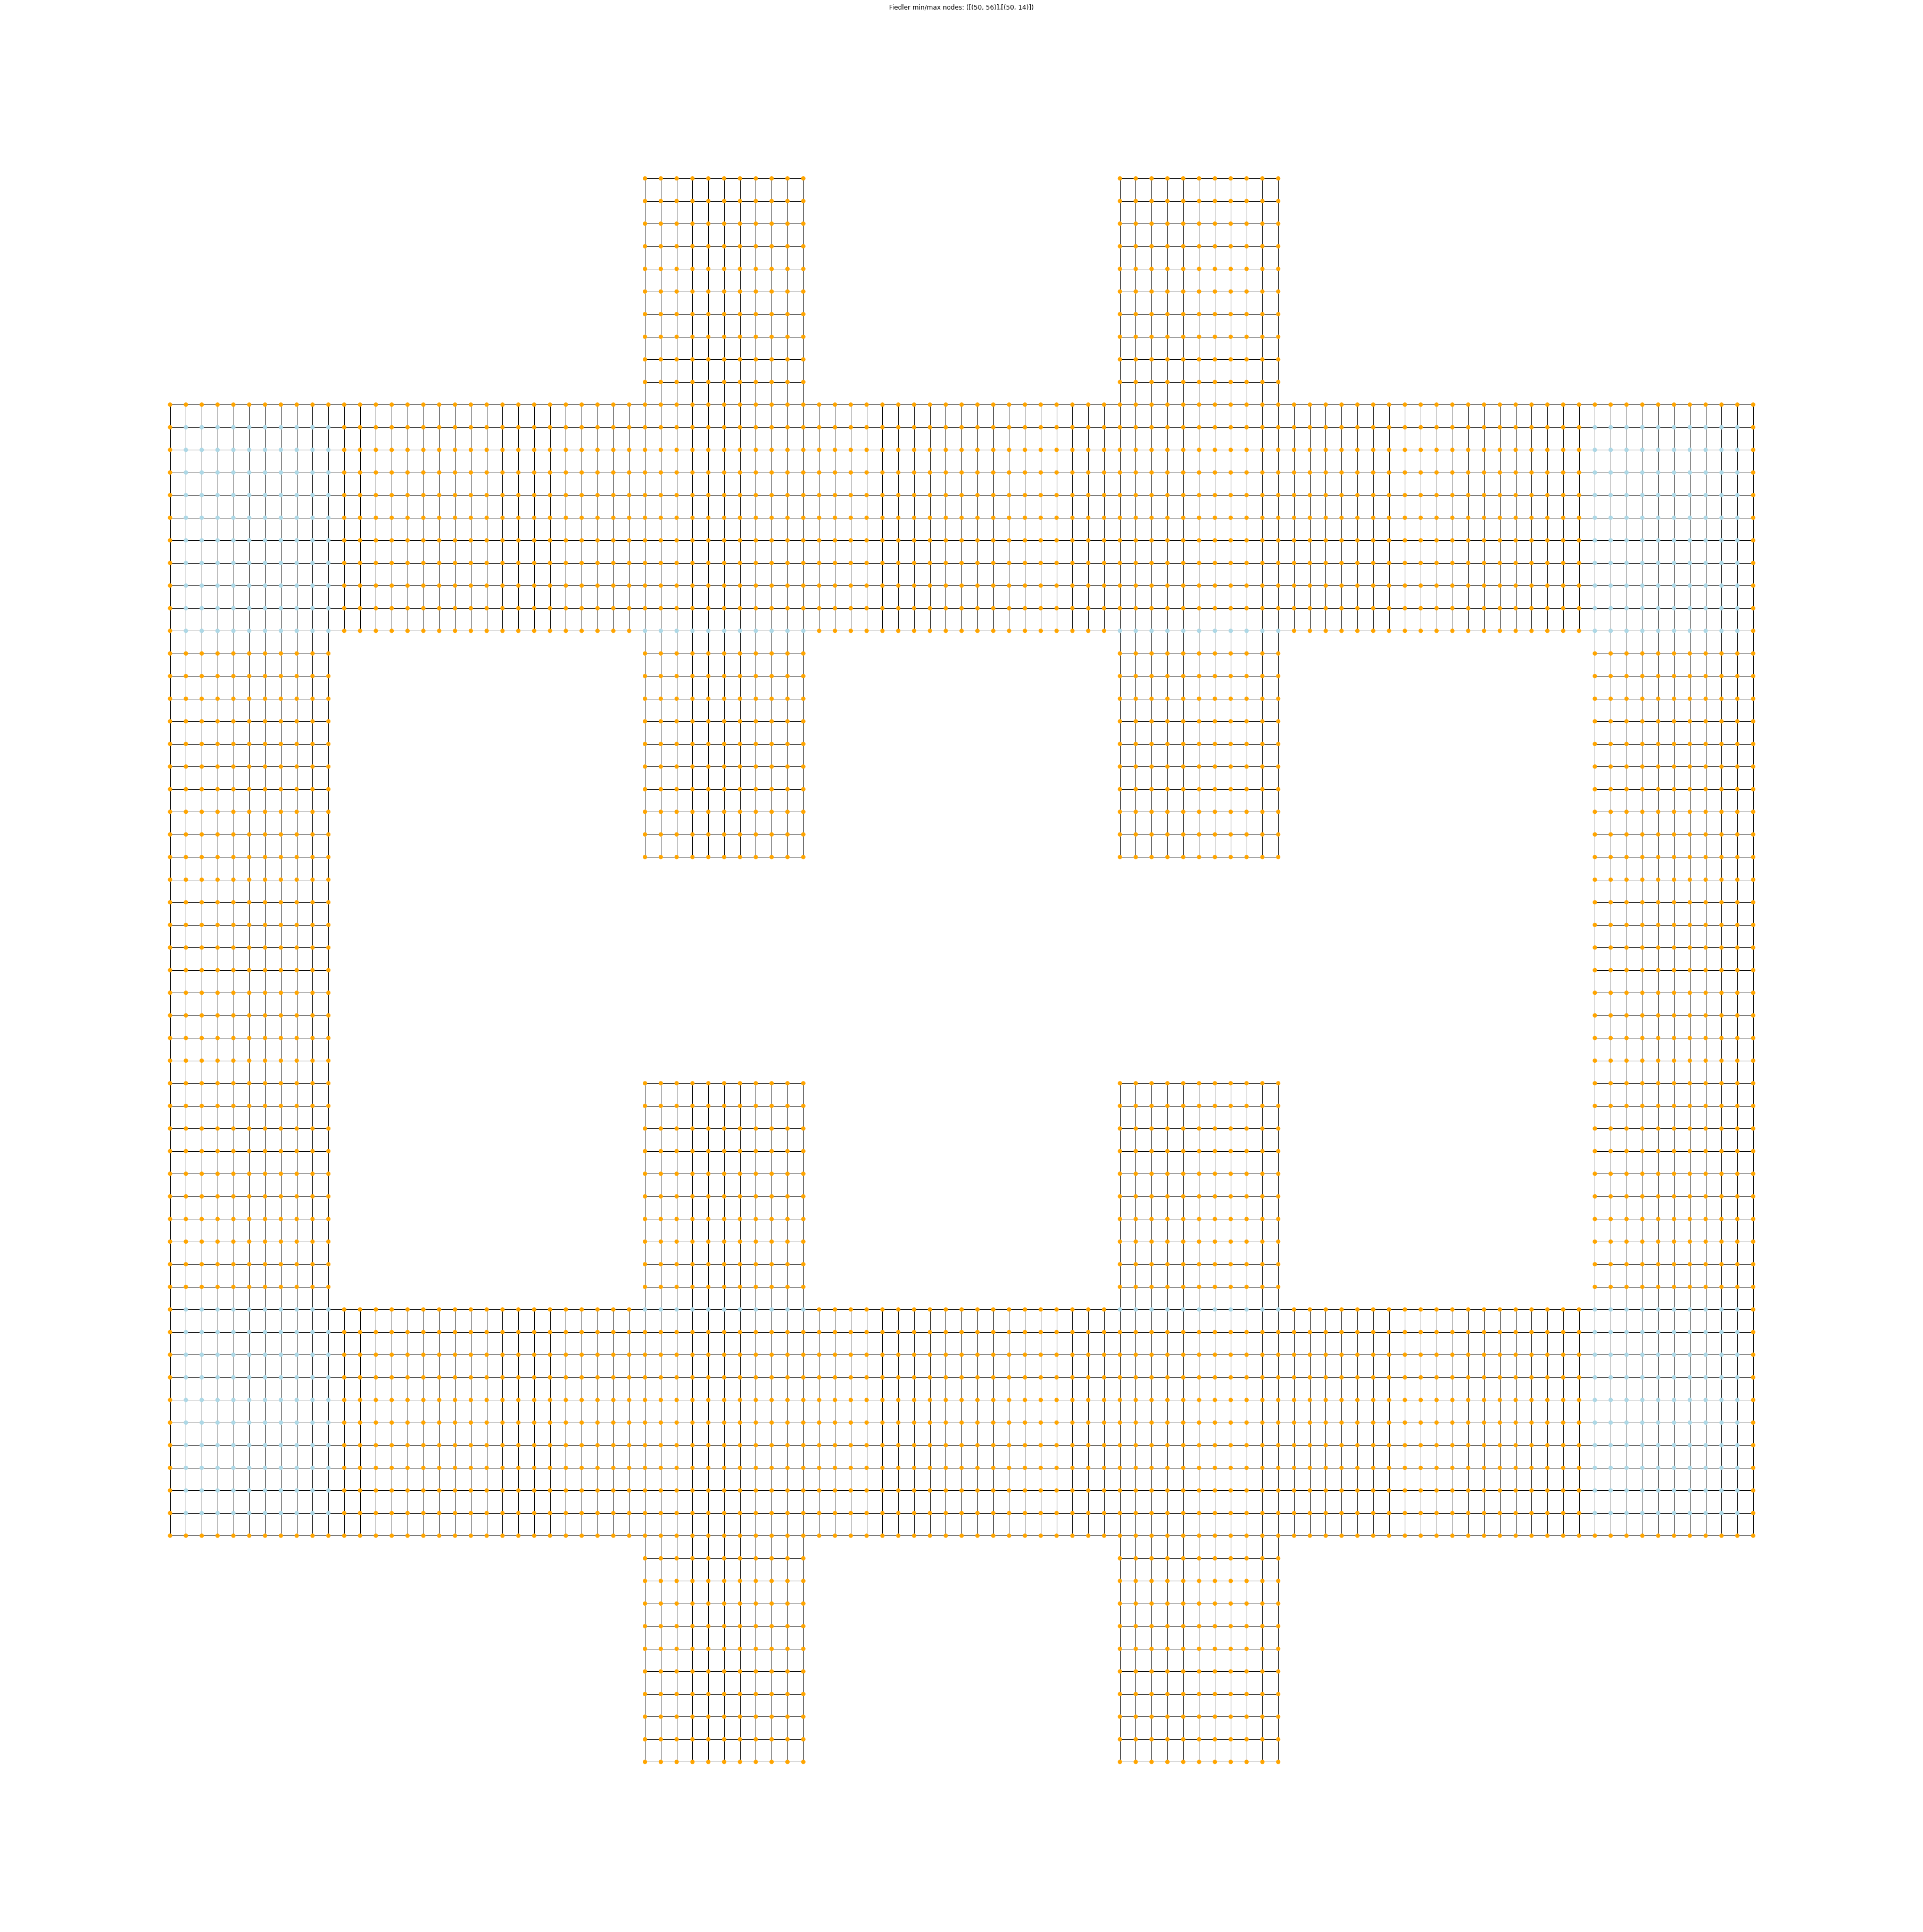

In [222]:
conj, min_node, max_node, is_plan, is_conv, is_strict_conv, bound_set = check_conjecture(
    brick_G, verbose=False, pos=brick_pos, with_lab=False, sz=50, fig_size=(50,50))

---

In [223]:
scale2 = 30

In [224]:
inner_boundary2 = scale2*np.array([[1,2],[3,2],[3,3],[4,3],[4,2],[6,2],[6,3],[7,3],[7,2],[9,2],[9,5],[7,5],[7,4],[6,4],[6,5],[4,5],[4,4],[3,4],[3,5],[1,5],[1,2]])
outer_boundary2 = scale2*np.array([[0, 1], [3,1], [3,0],[4,0],[4,1],[6,1],[6,0],[7,0],[7,1],[10,1],[10,6],[7,6],[7,7],[6,7],[6,6],[4,6],[4,7],[3,7],[3,6],[0,6],[0,1]])
outer_poly2 = Polygon(outer_boundary2)
inner_poly2 = Polygon(inner_boundary2)

In [225]:
brick_G2 = nx.grid_2d_graph(int(10.5*scale2), int(7.5*scale2))
print(len(brick_G2.nodes))

brick_nodes2 = list(brick_G2.nodes) # these nodes now give us positions 
for node in brick_nodes2:
    if not point_in_region(node, outer_poly2, inner_poly2):
        brick_G2.remove_node(node)
    
print(len(brick_G2.nodes))
brick_pos2 = {(x,y):(x,y) for x,y in brick_G2.nodes()}

70875
31620


In [ ]:
conj2, min_node2, max_node2, is_plan2, is_conv2, is_strict_conv2, bound_set2 = check_conjecture(
    brick_G2, verbose=False, plot=False)

---
---
## PREVIOUS INVESTIGATIONS

### D. Testing code: making sure known counterexamples show up as false
Using non-planar example from Stefan

In [25]:
G_CE = nx.Graph()
G_CE.add_nodes_from(range(1,21))

for i in [1, 6, 11, 16]:
    for j in range(1, 5):
        G_CE.add_edge(i, i+j)

for k in range(1, 16):
    G_CE.add_edge(k, k+5)

Fiedler vector [-0.29215636 -0.29215636 -0.29215636 -0.29215636 -0.29215636 -0.12101513
 -0.12101513 -0.12101513 -0.12101513 -0.12101513  0.12101513  0.12101513
  0.12101513  0.12101513  0.12101513  0.29215636  0.29215636  0.29215636
  0.29215636  0.29215636]
Planar? False
Convex? True
Strictly convex? False

Maximum nodes in Fiedler vector: [16, 17, 18, 19, 20]
All on boundary? False
Minimum nodes in Fiedler vector: [1, 2, 3, 4, 5]
All on boundary? False
Result: False


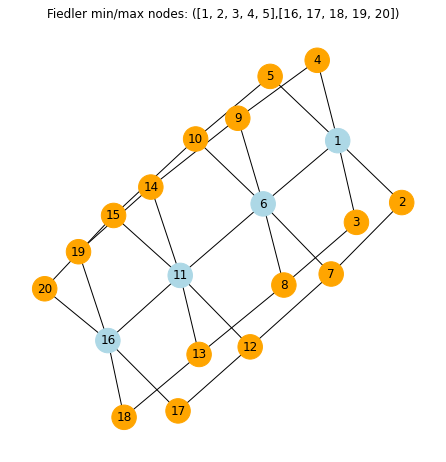

In [26]:
conj, min_node, max_node, is_plan, is_conv, is_strict_conv, bound_set = check_conjecture(G_CE)

---
---

### B. Run testing procedure for specific graph types

Functions defined in or relevant from (A) that will be used: nx.is_planar, boundary, is_convex, nx.fiedler_vector

In [14]:
abc = [0, 10, 20, 30, 40, 50, 60]
sel = [0, 3, 4]

vals = [abc[i] for i in range(len(abc)) if i in sel]
vals

[0, 30, 40]

#### 1. Grid graph tests 

Fiedler vector [-2.33052347e-01 -2.33052347e-01 -2.33052347e-01 -2.33052347e-01
 -2.33052347e-01 -1.86893471e-01 -1.86893471e-01 -1.86893471e-01
 -1.86893471e-01 -1.86893471e-01 -1.03718052e-01 -1.03718052e-01
 -1.03718052e-01 -1.03718052e-01 -1.03718052e-01 -2.16403212e-16
 -2.34324491e-16 -3.40654202e-16 -4.25975076e-16 -5.66707891e-16
  1.03718052e-01  1.03718052e-01  1.03718052e-01  1.03718052e-01
  1.03718052e-01  1.86893471e-01  1.86893471e-01  1.86893471e-01
  1.86893471e-01  1.86893471e-01  2.33052347e-01  2.33052347e-01
  2.33052347e-01  2.33052347e-01  2.33052347e-01]
Planar? True
Convex? True
Strictly convex? False

Maximum nodes in Fiedler vector: [(6, 0), (6, 1), (6, 2), (6, 3), (6, 4)]
All on boundary? True
Minimum nodes in Fiedler vector: [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]
All on boundary? True
Result: True


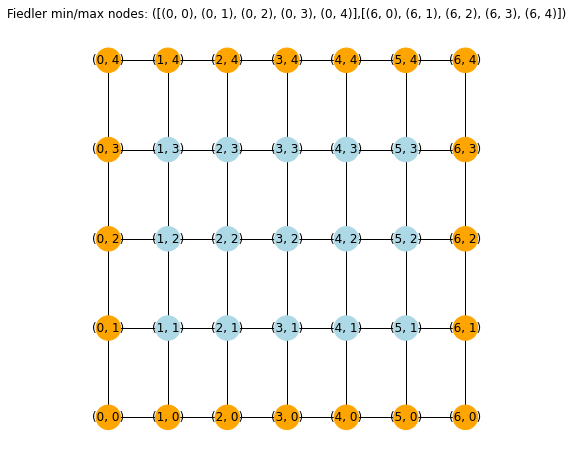

In [16]:
# Create m x n 2D grid/lattice graph
m = 7
n = 5

G = nx.grid_2d_graph(m, n)
pos = {(x,y):(x,y) for x,y in G.nodes()}
conj, min_node, max_node, is_plan, is_conv, is_strict_conv, bound_set = check_conjecture(G, pos);

#### 2. Random power-law tree tests

Fiedler vector [ 0.40676094  0.38971973  0.35635126  0.30805349  0.24684986  0.17530448
  0.09641473  0.0134857  -0.07000831 -0.14750809 -0.19947786 -0.20820039
 -0.07306955 -0.15395815 -0.15395815 -0.15395815 -0.20820039 -0.20820039
 -0.20820039 -0.20820039]
Planar? True
Convex? True
Strictly convex? True

Maximum nodes in Fiedler vector: [0]
All on boundary? True
Minimum nodes in Fiedler vector: [11, 16, 17, 18, 19]
All on boundary? True
Result: True


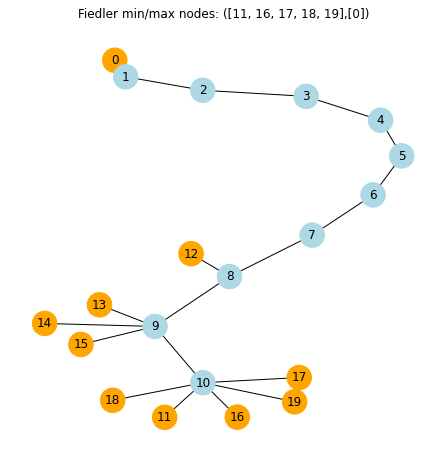

In [17]:
# note: the random tree sequence generation sometimes fails here; just try running the code cell again

n = 20

G = nx.random_powerlaw_tree(n)
conj, min_node, max_node, is_plan, is_conv, is_strict_conv, bound_set = check_conjecture(G);

---
---

### C. Generate results for suite of random graphs 
In particular: generate random *planar* graphs using Delaunay triangulation

In [18]:
from scipy.spatial import Delaunay
from numpy import random

In [19]:
# define procedure for generating random graph this way

def random_planar(n):
    # 1) randomly sample n points from [0, 1] x [0, 1] space
    points = np.array([[random.uniform(),random.uniform()]  for i in range(n)])
    
    # 2) compute Delaunay triangulation of points
    tris = Delaunay(points)
    
    # 3) generate graph based on triangulation
    G = nx.Graph()
    G.add_nodes_from(range(len(points)))
    for tri in tris.simplices:
        for i in range(3):
            G.add_edge(tri[i], tri[(i+1)%3])   
        
    return points, tris, G

Testing: running through multiple randomly generated samples

In [20]:
V = 15 # number of vertices
N = 10 # number of examples to try

counterexamples = []

Fiedler vector [-0.08899176  0.38089967  0.27798872  0.30624669  0.20203077 -0.28129971
 -0.2146953  -0.30596703 -0.14573083  0.10761027  0.33016394 -0.01382476
 -0.32939307 -0.37750723  0.15246962]
Planar? True
Convex? True
Strictly convex? False

Maximum nodes in Fiedler vector: [1]
All on boundary? True
Minimum nodes in Fiedler vector: [13]
All on boundary? True
Result: True


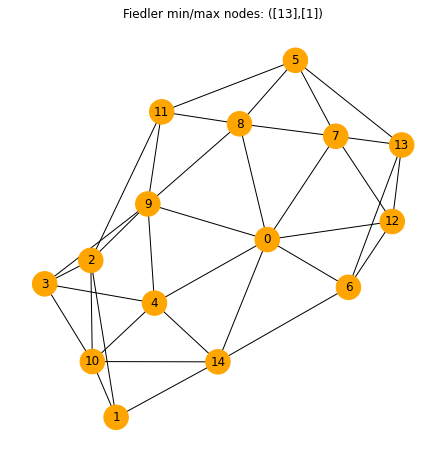

0 tests done
Fiedler vector [-0.34435786 -0.28131803 -0.28787905 -0.08997352  0.45937619 -0.18820595
  0.01667458 -0.29978888  0.20362694  0.09074724  0.45110301  0.22803609
 -0.09908444 -0.08719802  0.22824169]
Planar? True
Convex? True
Strictly convex? False

Maximum nodes in Fiedler vector: [4]
All on boundary? True
Minimum nodes in Fiedler vector: [0]
All on boundary? True
Result: True


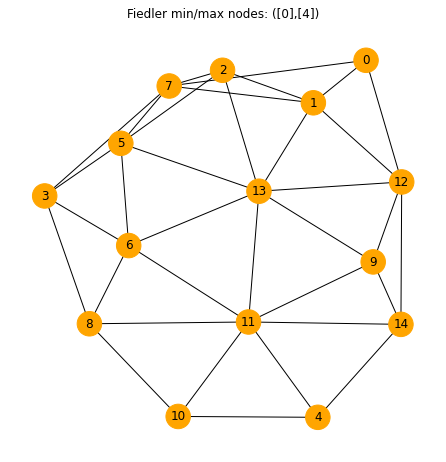

Fiedler vector [ 0.02057709  0.35701755 -0.22355068 -0.01454923 -0.04031403  0.05673104
  0.57770041  0.29063828 -0.2585145  -0.0796977  -0.20787365 -0.24650423
 -0.362335    0.26769173 -0.13701708]
Planar? True
Convex? True
Strictly convex? False

Maximum nodes in Fiedler vector: [6]
All on boundary? True
Minimum nodes in Fiedler vector: [12]
All on boundary? True
Result: True


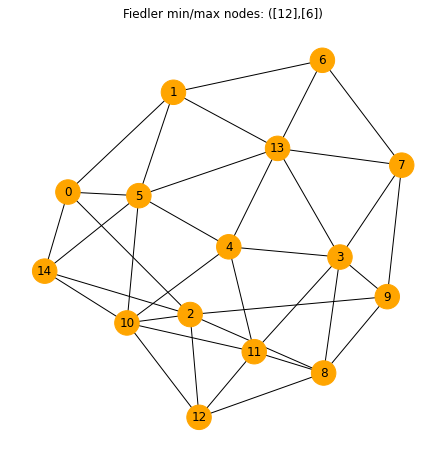

Fiedler vector [-0.30223505 -0.15869418  0.38480126  0.23755199 -0.31178377  0.19133362
 -0.28153896  0.34230989  0.32734296 -0.09956855 -0.07968422 -0.19862955
 -0.36812157  0.16578144  0.15113469]
Planar? True
Convex? True
Strictly convex? False

Maximum nodes in Fiedler vector: [2]
All on boundary? True
Minimum nodes in Fiedler vector: [12]
All on boundary? True
Result: True


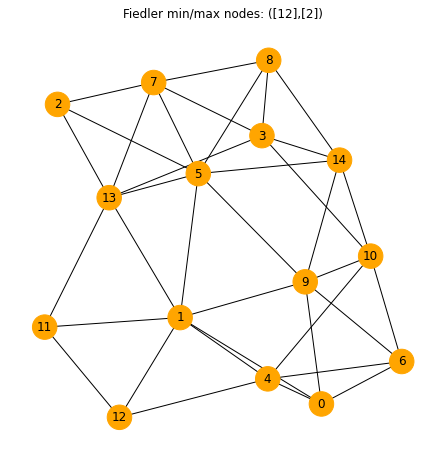

Fiedler vector [ 0.0904851  -0.18115785  0.11365855 -0.36615585  0.0241978  -0.06737087
 -0.2549547   0.3200161  -0.54980412  0.30555118 -0.06497142  0.31440468
  0.20820244 -0.1600392   0.26793814]
Planar? True
Convex? True
Strictly convex? False

Maximum nodes in Fiedler vector: [7]
All on boundary? True
Minimum nodes in Fiedler vector: [8]
All on boundary? True
Result: True


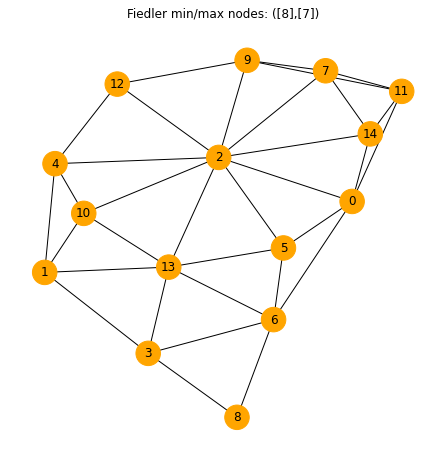

Fiedler vector [-0.08880396 -0.17046923  0.37181127 -0.32455978  0.38700742 -0.22530917
  0.03268914 -0.34001828 -0.31096222  0.08932278  0.05842789 -0.10812398
 -0.06850362  0.21734826  0.48014348]
Planar? True
Convex? True
Strictly convex? False

Maximum nodes in Fiedler vector: [14]
All on boundary? True
Minimum nodes in Fiedler vector: [7]
All on boundary? True
Result: True


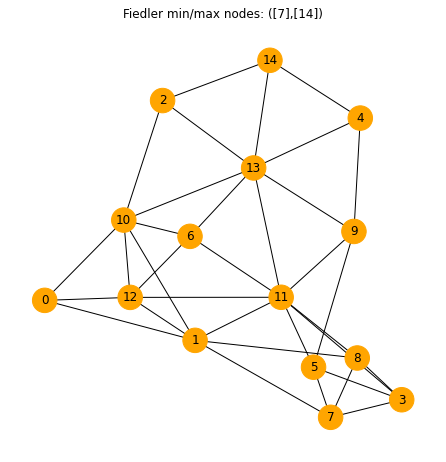

Fiedler vector [ 0.30608692  0.37835986  0.36666891 -0.00933878  0.08193339  0.12521819
 -0.41207571  0.21747141  0.1744042  -0.35939103 -0.14616357 -0.0904753
 -0.03232077 -0.20341904 -0.39695867]
Planar? True
Convex? True
Strictly convex? False

Maximum nodes in Fiedler vector: [1]
All on boundary? True
Minimum nodes in Fiedler vector: [6]
All on boundary? True
Result: True


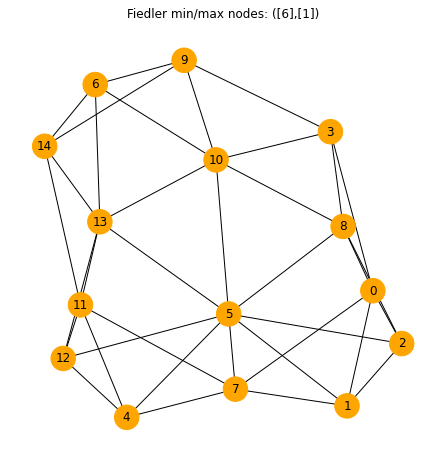

Fiedler vector [-0.38211468  0.2347851  -0.00421677 -0.50825973  0.11676608  0.20751704
  0.27143598 -0.21310124  0.1285314  -0.41913886  0.23821357  0.05965461
 -0.15215582  0.21162183  0.2104615 ]
Planar? True
Convex? True
Strictly convex? False

Maximum nodes in Fiedler vector: [6]
All on boundary? True
Minimum nodes in Fiedler vector: [3]
All on boundary? True
Result: True


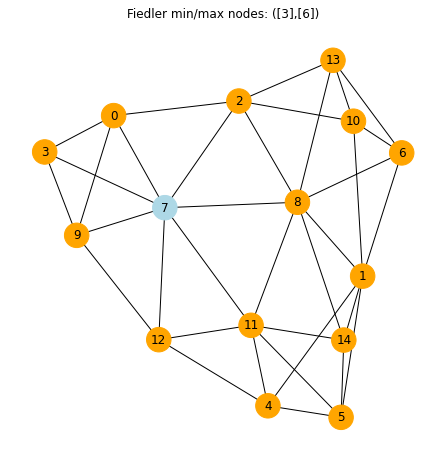

Fiedler vector [ 0.40868012 -0.30031641  0.48409013 -0.13993873  0.02771206  0.19027324
 -0.34327945  0.02302658  0.26131608  0.24796386 -0.34440237 -0.17150915
 -0.21394373 -0.03707172 -0.09260051]
Planar? True
Convex? True
Strictly convex? False

Maximum nodes in Fiedler vector: [2]
All on boundary? True
Minimum nodes in Fiedler vector: [10]
All on boundary? True
Result: True


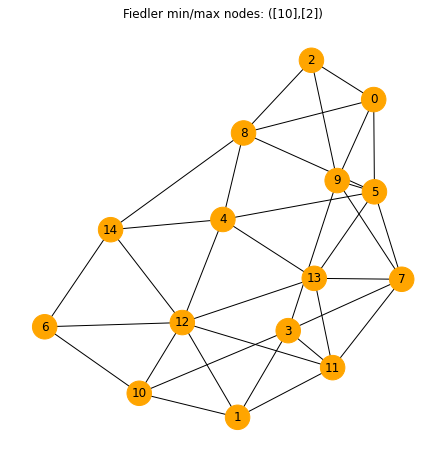

Fiedler vector [ 0.14952483 -0.57238739 -0.29548504  0.28590145  0.34359156 -0.35102293
  0.20982927 -0.09048546 -0.14016617  0.04629973 -0.13221442  0.30274922
  0.14302541 -0.07409342  0.17493337]
Planar? True
Convex? True
Strictly convex? False

Maximum nodes in Fiedler vector: [4]
All on boundary? True
Minimum nodes in Fiedler vector: [1]
All on boundary? True
Result: True


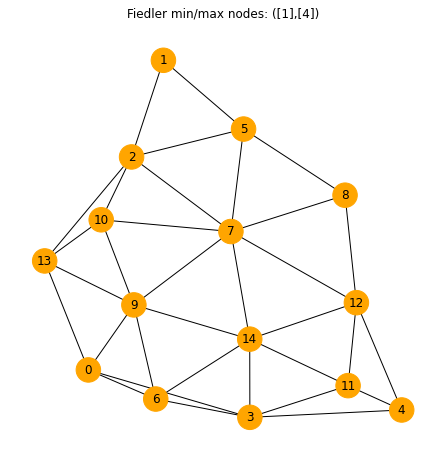

In [21]:
for i in range(N):
    points, tris, G = random_planar(V)
    conj, min_node, max_node, is_plan, is_conv, is_strict_conv, bound_set = check_conjecture(G)
    
    if not conj:
        print('COUNTEREXAMPLE')
        counterexamples.append(G)
    
    if(i%50 == 0):
        print(f"{i} tests done")

In [22]:
print(counterexamples)

[]


Example using random_planar() function, printed out

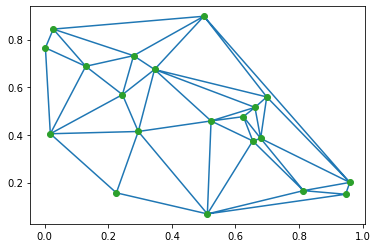

In [23]:
points, tris, G = random_planar(20)

# plot the Delaunay triangulation directly
plt.triplot(points[:,0], points[:,1], tris.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

(True, <networkx.algorithms.planarity.PlanarEmbedding object at 0x7fe2c891d280>)


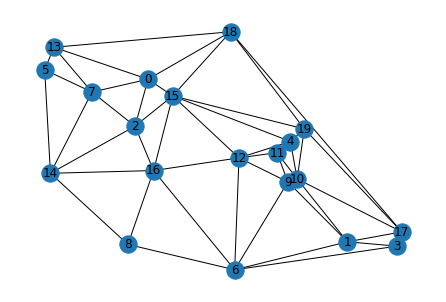

In [24]:
# plot our graph (and check planarity)
print(nx.check_planarity(G))
nx.draw(G, pos=points, with_labels=True) 


---
---
---
---
---
---
---
---

---
<font color='red'> DEPRECATED: this does not work anymore because not being updated </font>: <br> original: using connected Erdos-Renyi random graphs via repeated generation, and then just testing for planar, conv, strict_conv?
<br> Not useful: the boundary of these is generally (a large fraction of) the entire thing! because of how erdos-renyi are constructed..

In [29]:
n = 30
p = 0.05
test_count = 100

graphs = []
conv = []
strict_conv = []
planar = []
conjecture_res = []

for i in range(test_count):
    G = nx.gnp_random_graph(n, p)
    while not nx.is_connected(G):
        G = nx.gnp_random_graph(n, p)
    
    conj, min_node, max_node, is_plan, is_conv, is_strict_conv, bound_set = check_conjecture(G, verbose=False, plot=False);
#     print('computations done')
    
    graphs.append(G)
    conv.append(is_conv)
    strict_conv.append(is_strict_conv)
    planar.append(is_plan)
    conjecture_res.append((min_node in bound_set and max_node in bound_set))
    
    if(i % 10 == 0):
        print("Test", i, "done")

In [ ]:
# counts number of "True"s in each list
print(sum(conjecture_res))
print(sum(planar))
print(sum(conv))
print(sum(strict_conv))

In [ ]:
nx.draw(graphs[1])

In [ ]:
bset = set(compute_boundary(graphs[1]))
colors = ['orange' if n in bset else 'lightblue' for n in list(graphs[1].nodes)]
nx.draw(graphs[1], node_color=colors, with_labels=True, node_size=600)